In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=3,style='whitegrid')

In [68]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

In [85]:
df_pkpd = pd.read_csv('PD_Parameters_result.csv',index_col=0)
df_pkpd = df_pkpd.fillna(df_pkpd.mean())

In [100]:
df_pkpd.columns

Index(['lacosamide_Hill', 'lacosamide_50', 'levetiracetam_Hill',
       'levetiracetam_50', 'midazolam_Hill', 'midazolam_50',
       'pentobarbital_Hill', 'pentobarbital_50', 'phenobarbital_Hill',
       'phenobarbital_50', 'propofol_Hill', 'propofol_50', 'valproate_Hill',
       'valproate_50'],
      dtype='object')

# Effect of IIC Burden on Outcome

In [86]:
df_coarsen = setup_coarsen_data(iic_burden,window = 6,summarize='mean')
# df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
#                      index_col=0, header=0)
# df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
#                    'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)

# df_pkpd = pd.read_csv('PD_Parameters_result.csv')
df_coarsen_1 = df_coarsen[iic_burden['Cname']+['mRS', 'E'
                                               ,'lacosamide', 'levetiracetam', 'midazolam', 
                                               'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

df_coarsen_1 = df_coarsen_1.join(df_pkpd)
continuous = ['Age','iGCS-Total','iGCS = T?','Worst GCS in 1st 24h','Worst GCS intub','APACHE II 1st 24h',
              'SBP highest (1st 24h)','SBP lowest (1st 24h)','DBP highest (1st 24h)','DBP lowest (1st 24h)',
              'HR highest (1std 24h)','HR lowest (1st 24h)','premorbid MRS']
discrete = set(iic_burden['Cname']).difference(continuous)

df_coarsen_1['Y'] = (df_coarsen_1['mRS'] > 3).astype(float)

n_thresholds = 5
thresholds = [0,0.25,0.5,0.75,1]#list(np.linspace(0,1,num=n_thresholds))
gain = thresholds[1]-thresholds[0]
iic_level = df_coarsen_1['E']>2
for threshold in thresholds:
    iic_level = iic_level + gain*(df_coarsen_1['E']>threshold).astype(int)
    
iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)
drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
              (df_coarsen_1['propofol']>1) + 
              (df_coarsen_1['midazolam']>0) +
              (df_coarsen_1['lacosamide']>0) +
              (df_coarsen_1['pentobarbital']>0) +
              (df_coarsen_1['phenobarbital']>0) +
              (df_coarsen_1['valproate']>0) ).astype(int)

df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
df_coarsen_1['drug'] = drug_level
df_coarsen_1['T'] = '('+df_coarsen_1['iic'].astype(str) +', '+df_coarsen_1['drug'].astype(str)+')'

In [106]:
df_coarsen_1.to_csv('mean_df_coarsen.csv')

In [88]:
thresholds

[0, 0.25, 0.5, 0.75, 1]

<AxesSubplot:ylabel='Frequency'>

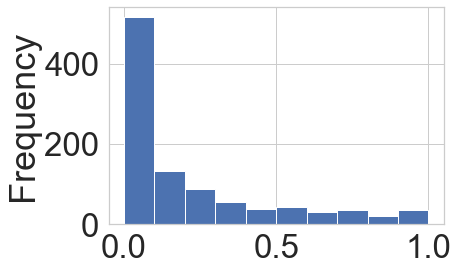

In [89]:
df_coarsen_1['E'].plot(kind='hist')

In [90]:
df_coarsen_1.groupby(by='T').count().mean(axis=1)

T
(0.0, 0)       9.000000
(0.0, 1)      26.000000
(0.12, 0)    191.000000
(0.12, 1)    470.000000
(0.38, 0)     35.000000
(0.38, 1)     99.000000
(0.62, 0)     25.854167
(0.62, 1)     63.000000
(0.88, 0)     22.000000
(0.88, 1)     55.854167
dtype: float64

In [91]:
df_coarsen_1.groupby(by='T').mean()

,Gender,Age,Marrital,iGCS-Total,iGCS = T?,Worst GCS in 1st 24h,Worst GCS intub,APACHE II 1st 24h,SBP highest (1st 24h),SBP lowest (1st 24h),...,pentobarbital_Hill,pentobarbital_50,phenobarbital_Hill,phenobarbital_50,propofol_Hill,propofol_50,valproate_Hill,valproate_50,Y,drug
T,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0)",0.888889,50.561111,0.444444,7.111111,0.777778,5.444444,0.888889,24.555556,184.333333,123.888889,...,3.761450e-13,29.740157,17.523652,31.258455,22.125554,27.114267,9.440983,50.069078,0.888889,0
"(0.0, 1)",0.730769,57.662692,0.423077,7.384615,0.730769,5.346154,0.923077,23.923077,165.307692,114.230769,...,3.761450e-13,29.740157,17.744300,30.957617,22.387597,27.782963,9.440983,50.069078,0.692308,1
"(0.12, 0)",0.460733,60.284817,0.534031,11.952880,0.209424,11.062827,0.256545,14.188482,154.267016,120.172775,...,3.761450e-13,29.740157,17.523652,31.258455,22.697542,28.158580,9.440983,50.069078,0.654450,0
"(0.12, 1)",0.489362,59.116255,0.470213,9.031915,0.521277,7.370213,0.625532,19.387234,158.570213,116.400000,...,3.745444e-13,29.627707,17.569315,31.284144,22.875768,28.869992,9.469598,50.025131,0.804255,1
"(0.38, 0)",0.485714,56.467143,0.428571,12.828571,0.142857,11.171429,0.257143,13.257143,151.914286,117.085714,...,3.761450e-13,29.740157,17.523652,31.258455,22.175555,27.355473,9.440983,50.069078,0.685714,0
"(0.38, 1)",0.424242,58.911313,0.515152,10.030303,0.404040,8.787879,0.515152,19.555556,154.969697,120.262626,...,3.685718e-13,30.217718,17.141040,30.776188,23.559464,28.799567,9.415149,50.318665,0.898990,1
"(0.62, 0)",0.423077,61.145000,0.653846,12.000000,0.230769,10.653846,0.230769,16.192308,149.461538,120.000000,...,3.761450e-13,29.740157,17.523652,31.258455,22.397371,27.804010,9.440983,50.069078,0.807692,0
"(0.62, 1)",0.412698,61.514444,0.492063,9.428571,0.412698,7.857143,0.523810,20.492063,160.396825,123.460317,...,3.704967e-13,29.604269,17.697131,31.371367,23.866538,29.327473,8.691698,48.494853,0.952381,1
"(0.88, 0)",0.363636,63.906818,0.681818,11.363636,0.227273,10.181818,0.227273,16.636364,157.727273,121.363636,...,3.761450e-13,29.740157,17.523652,31.258455,22.956908,28.551287,9.440983,50.069078,0.818182,0


## Controlling for age

In [92]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

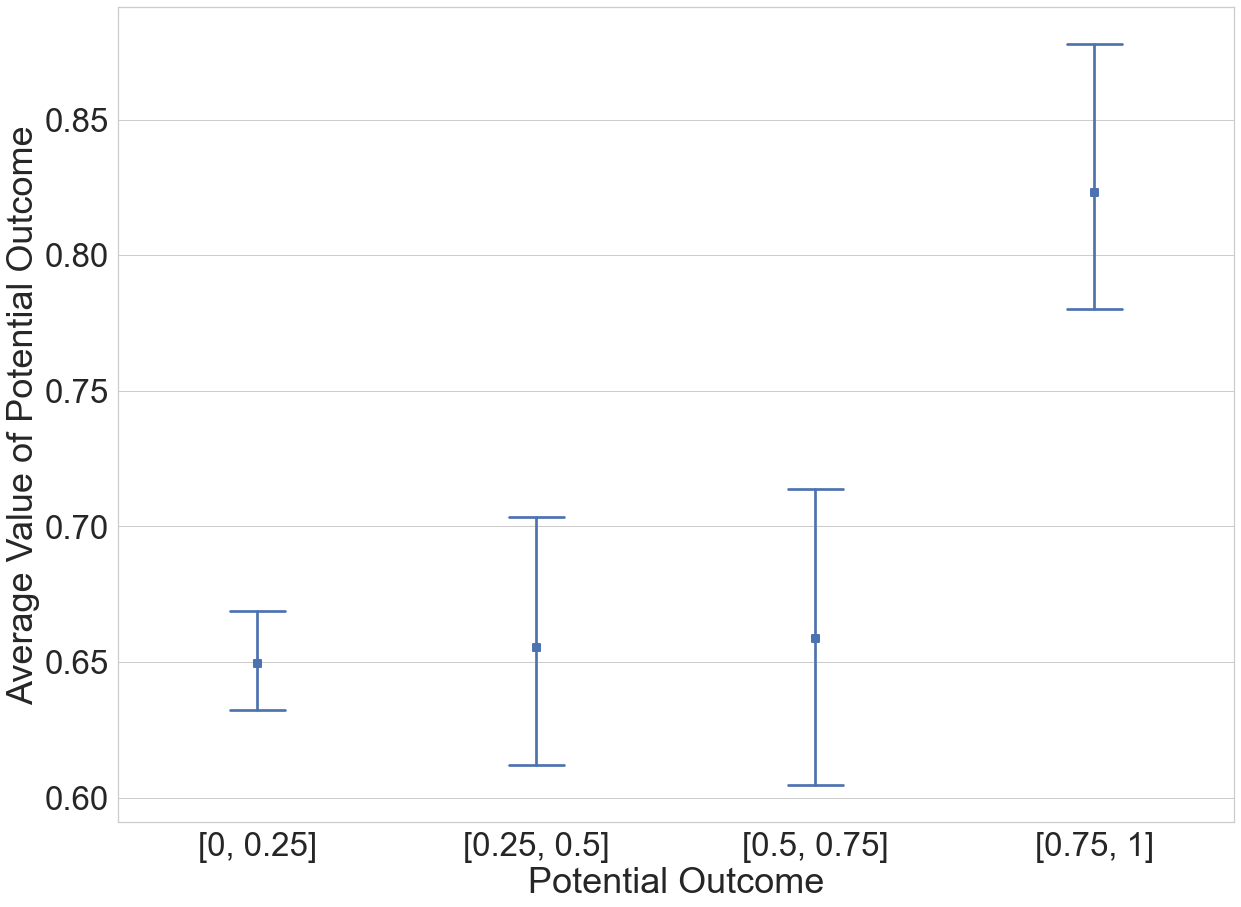

In [93]:
out_age = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_age.to_csv('new_mean_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0_age = out_age[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0_age = out_age[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1_age = out_age[columns]

apo_tight_0_age = pd.DataFrame(apo_0_age.values*(diam_0_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_0_age.index,columns=apo_0_age.columns)
apo_tight_0_age.mean(axis=0)

apo_tight_1_age = pd.DataFrame(apo_1_age.values*(diam_1_age<10).astype(int).replace(0, np.nan).values,
                         index=apo_1_age.index,columns=apo_1_age.columns)
apo_tight_1_age.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_age.png')

In [94]:
apo_tight_0_age.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_age.csv')

In [95]:
['Y((%f, 0))'%(threshold-gain/2) for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]

['Y((0.125000, 0))',
 'Y((0.375000, 0))',
 'Y((0.625000, 0))',
 'Y((0.875000, 0))']

## Controlling for All Preadmission Covariates

In [96]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))

m_c = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

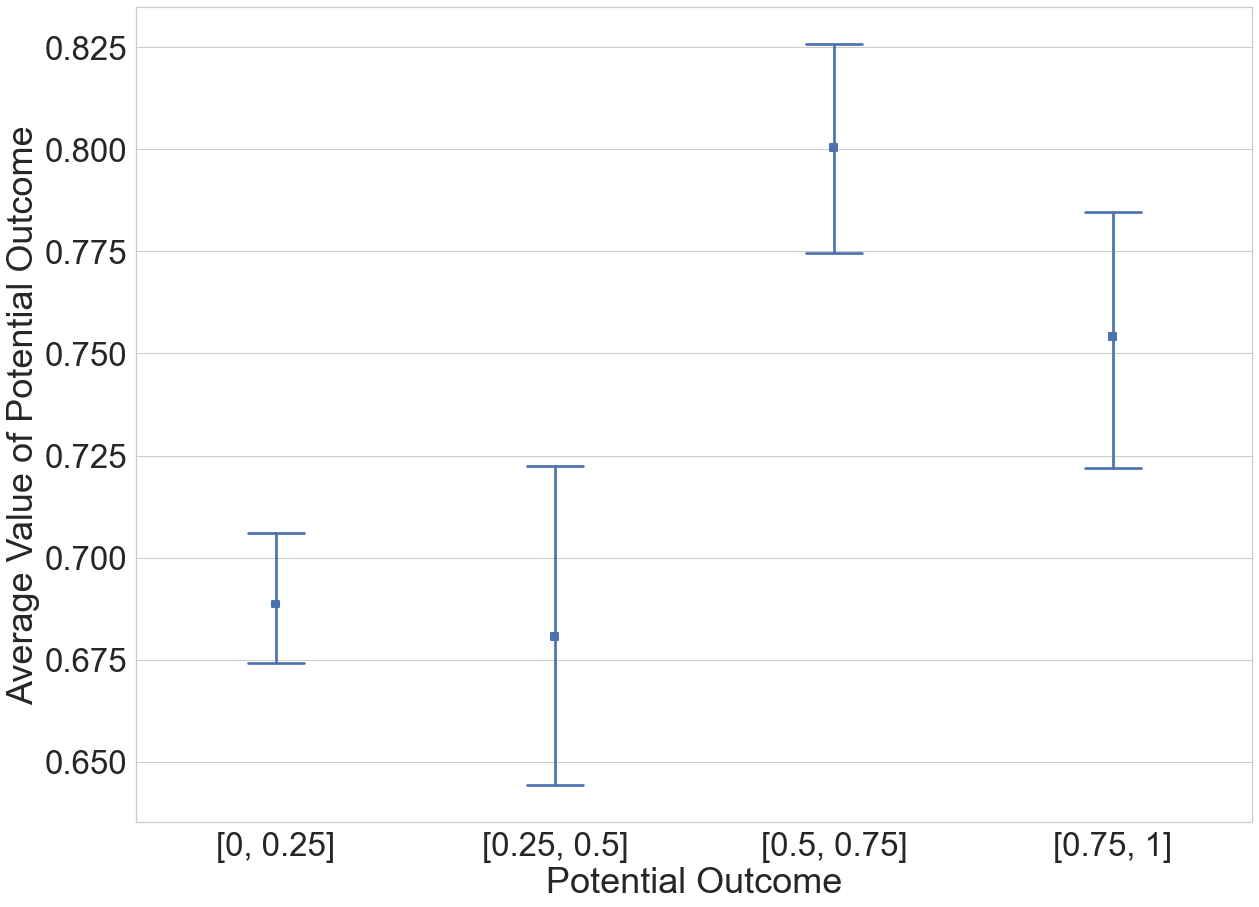

In [97]:
out_c = m_c.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_mean_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<700).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], markersize=520)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_c.png')

In [98]:
apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_c.csv')

# Controlling for all pre-admission covariates and PKPD parameters

In [101]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[iic_burden['Cname']+list(df_pkpd.columns)+['Y','T']]
discrete = list(set(iic_burden['Cname']).difference(continuous))
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=3,
                k_est=5,
                discrete = discrete,
                C=0.01)

In [102]:
pd.concat(m.M_opt_list).to_csv('M_opt_mean.csv')

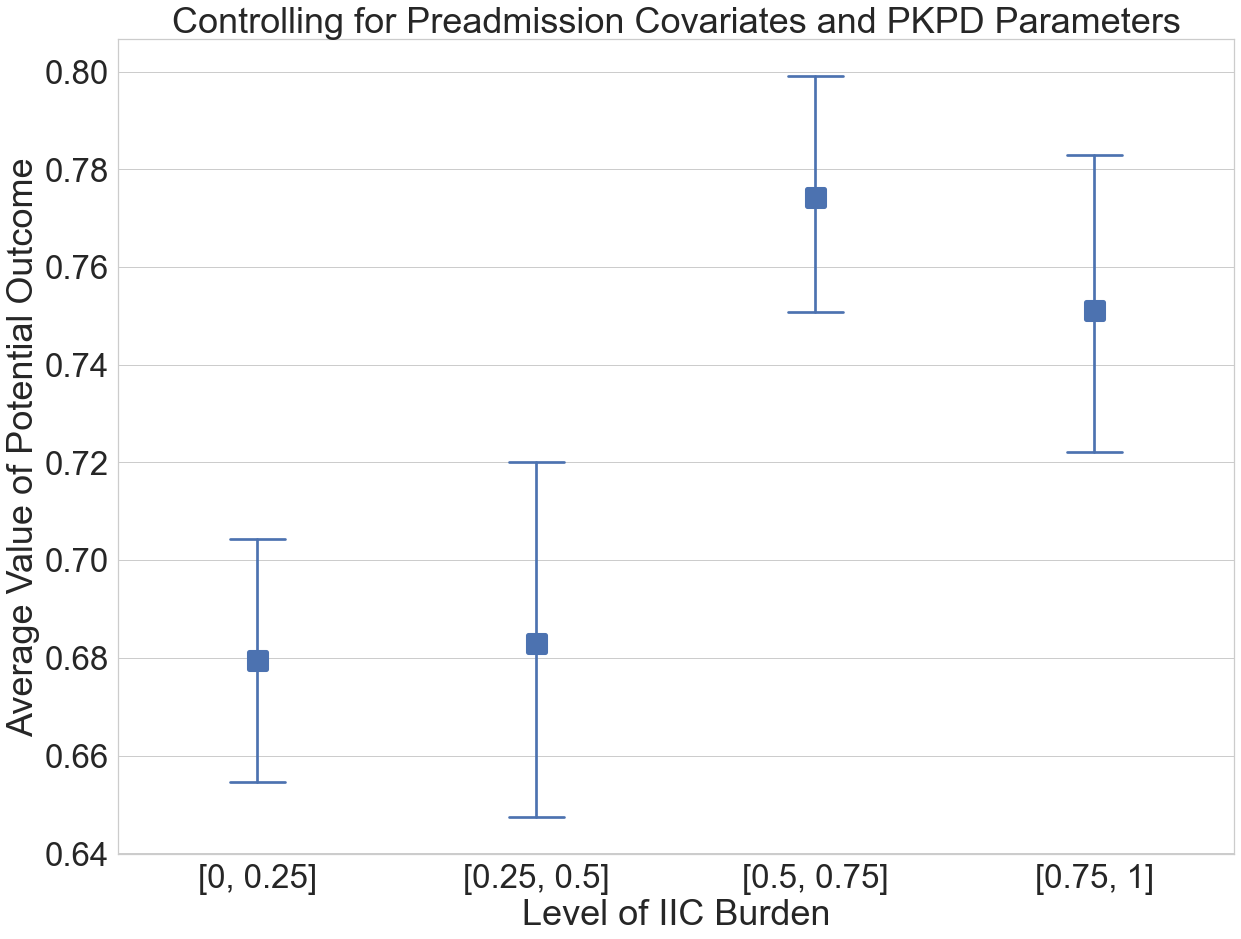

In [103]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_mean_c_pkpd.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<5000).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(apo_1_c_pkpd.values*(diam_1_c_pkpd<1000).astype(int).replace(0, np.nan).values,
                         index=apo_1_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_1_c_pkpd.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.pointplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax,join=False,capsize=.2,markers=['s'], scale = 2.5)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
plt.title('Controlling for Preadmission Covariates and PKPD Parameters')
fig.savefig('new_mean_c_pkpd.png')

In [104]:
apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}).dropna().to_csv('average_te_mean_c_pkpd.csv')

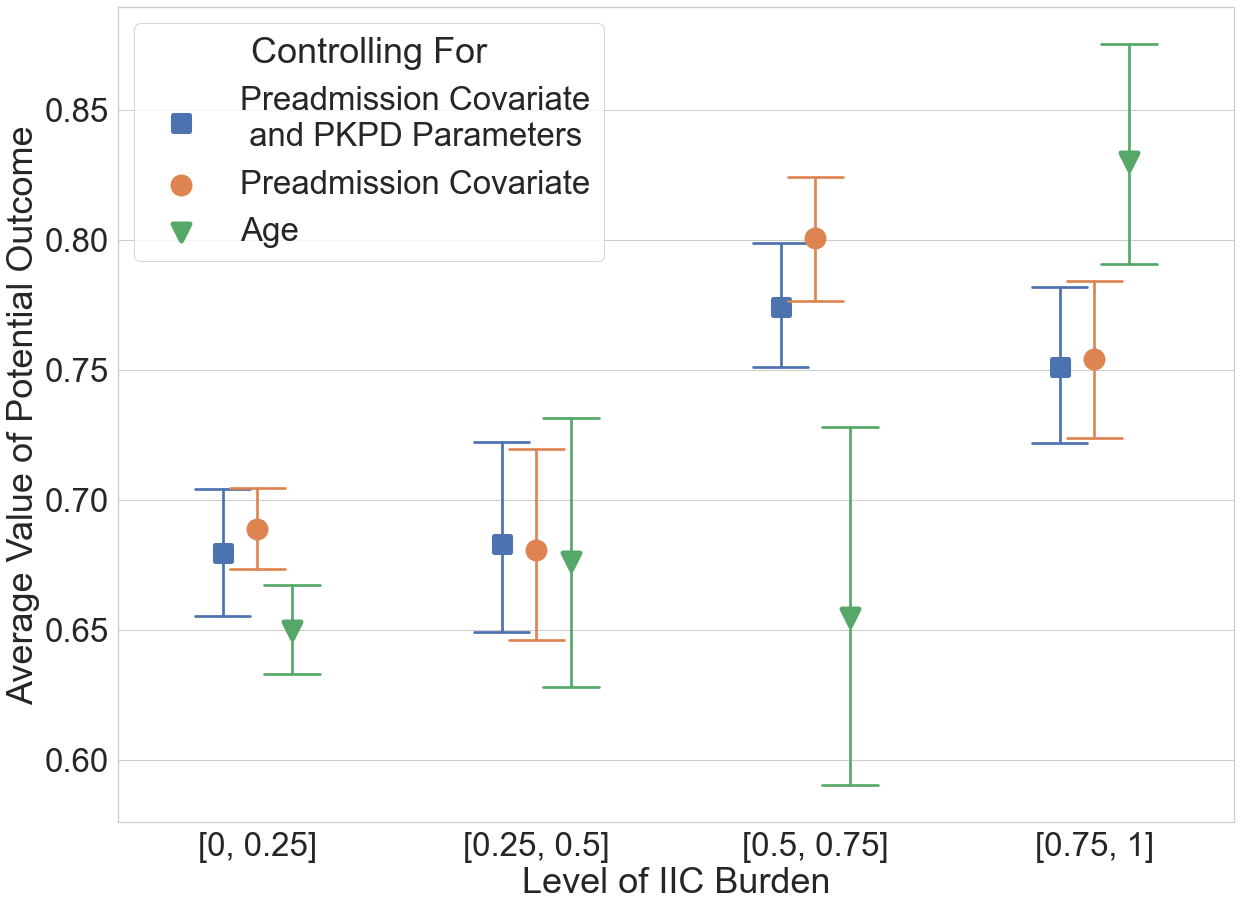

In [105]:
fig,ax = plt.subplots(figsize=(20,15))
control = ['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age']
df_apo = [apo_tight_0_c_pkpd,apo_tight_0_c,apo_tight_0]
df_plot = pd.DataFrame()
for i in range(3):
    df_plot_ = df_apo[i].mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'})
    df_plot_['Controlling For'] = [control[i] for k in range(df_plot_.shape[0])]
    df_plot = df_plot.append(df_plot_)

sns.pointplot(data=df_plot,
             x='index',y='Average Potential Outcome',
             hue='Controlling For',ax=ax,join=False,
             capsize=.2,markers=['s','o','v'],dodge=0.25,scale = 2.5)
# sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
# plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean.png')

# Heterogeneous Effects